In [7]:
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler


In [8]:
# Process data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load Train data and split into train set and valid set
num_train = 50000
indices = list(range(num_train))
train_index, valid_index = indices[10000:], indices[:10000]
train_sampler=SubsetRandomSampler(train_index)
valid_sampler=SubsetRandomSampler(valid_index)
train_dataset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
valid_dataset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True,
                                        download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
               batch_size=32, sampler=train_sampler, 
               num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=10, sampler=valid_sampler, 
               num_workers=4, pin_memory=True)

# Load test data
testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False,
                                       download=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, 
              batch_size=10,pin_memory=True,
              shuffle=True, num_workers=4)

# Define Class
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
# Save data in list for plot    
save_train_loss=[]
save_valid_loss=[]
save_test_loss=[]
save_train_acc=[]
save_valid_acc=[]
save_test_acc=[]

In [13]:
def main(iteration = 10, gpu_usage = False, opti = 'default', 
         Xavier = False, batch_norm = False):
    # detect GPU
    if gpu_usage:
        use_cuda  = torch.cuda.is_available()
    else:
        use_cuda = False
    # define network
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            if batch_norm:
                # batch normalization
                self.conv1 = nn.Conv2d(3, 96, 3, stride=1, padding=1)
                self.conv1_bn = nn.BatchNorm2d(96)
                self.pool1 = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(96, 256, 3, stride=1, padding=1)
                self.conv2_bn = nn.BatchNorm2d(256)
                self.pool2 = nn.MaxPool2d(2, 2)
                self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
                self.conv3_bn = nn.BatchNorm2d(384)
                self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
                self.conv4_bn = nn.BatchNorm2d(384)
                self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
                self.conv5_bn = nn.BatchNorm2d(256)
                self.pool5 = nn.MaxPool2d(2, 2)
                self.fc1 = nn.Linear(256 * 4 * 4, 4096)
                self.drop1 = nn.Dropout2d(0.2)
                self.fc2 = nn.Linear(4096, 4096)
                self.drop2 = nn.Dropout2d(0.2)
                self.fc3 = nn.Linear(4096, 10)
            else:
                # no batch normalization
                self.conv1 = nn.Conv2d(3, 96, 3, stride=1, padding=1)
                self.pool1 = nn.MaxPool2d(2, 2)
                self.conv2 = nn.Conv2d(96, 256, 3, stride=1, padding=1)
                self.pool2 = nn.MaxPool2d(2, 2)
                self.conv3 = nn.Conv2d(256, 384, 3, stride=1, padding=1)
                self.conv4 = nn.Conv2d(384, 384, 3, stride=1, padding=1)
                self.conv5 = nn.Conv2d(384, 256, 3, stride=1, padding=1)
                self.pool5 = nn.MaxPool2d(2, 2)
                self.fc1 = nn.Linear(256 * 4 * 4, 4096)
                self.drop1 = nn.Dropout2d(0.2)
                self.fc2 = nn.Linear(4096, 4096)
                self.drop2 = nn.Dropout2d(0.2)
                self.fc3 = nn.Linear(4096, 10)

            # Xavier init, need to check formula
            # Xavier Initialize for the whole network
            if Xavier:
                for m in self.modules():
                    if isinstance(m, nn.Conv2d):
                        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                        m.weight.data.normal_(0, math.sqrt(2. / n))
                    elif isinstance(m, nn.BatchNorm2d):
                        m.weight.data.fill_(1)
                        m.bias.data.zero_()
                        
        def forward(self, x):
            if batch_norm:
                # batch normalization
                x = self.pool1(F.relu(self.conv1_bn(self.conv1(x))))
                x = self.pool2(F.relu(self.conv2_bn(self.conv2(x))))
                x = F.relu(self.conv3_bn(self.conv3(x)))
                x = F.relu(self.conv4_bn(self.conv4(x)))
                x = self.pool5(F.relu(self.conv5_bn(self.conv5(x))))
                x = x.view(-1, 256 * 4 * 4)
                x = self.drop1(F.relu(self.fc1(x)))
                x = self.drop2(F.relu(self.fc2(x)))
                x = self.fc3(x)
            else:
                # no batch normalization
                x = self.pool1(F.relu(self.conv1(x)))
                x = self.pool2(F.relu(self.conv2(x)))
                x = F.relu(self.conv3(x))
                x = F.relu(self.conv4(x))
                x = self.pool5(F.relu(self.conv5(x)))
                x = x.view(-1, 256 * 4 * 4)
                x = self.drop1(F.relu(self.fc1(x)))
                x = self.drop2(F.relu(self.fc2(x)))
                x = self.fc3(x)
            return x

    net = Net()
#   net.apply(weights_init)
    
    ## using GPU
    if use_cuda:
        net.cuda()
        net = torch.nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
        cudnn.benchmark = True

    ## loss function
    criterion = nn.CrossEntropyLoss()
    if (opti == "Adam"):
        optimizer = optim.Adam(net.parameters(), lr = 0.001)
    else:
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

    ## starting training testinig validating
    start = timeit.default_timer()
    print('epoch, mini-batch\ttrain_loss\tvalid_loss\ttest_loss\ttrain_acc\tvalid_acc\ttest_acc')
    for epoch in range(iteration):  # loop over the dataset multiple times
        train_running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            # detect GPU
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_running_loss += loss.data[0]
            
            if i % 501 == 500:    # print every 1 mini-batches
                train_loss = train_running_loss / 500
                #print('train_loss = '+str(train_loss))
                train_running_loss = 0.0            
                # Train
                correct = 0
                total = 0
                for data in train_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    outputs = net(Variable(images))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                train_acc = 100 * correct / total
                #print('train_acc = '+str(train_acc))
                # Valid
                correct = 0
                total = 0
                valid_loss = 0
                for data in valid_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    v_images, v_labels = Variable(images), Variable(labels)
                    outputs = net(v_images)
                    valid_loss += criterion(outputs, v_labels).data[0]
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                valid_loss /= 1000
                valid_acc = 100 * correct / total
                # Test
                correct = 0
                total = 0
                test_loss = 0
                for data in test_loader:
                    images, labels = data
                    # detect GPU
                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    v_images, v_labels = Variable(images), Variable(labels)
                    outputs = net(v_images)
                    test_loss += criterion(outputs, v_labels).data[0]
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                test_loss /= 1000
                test_acc = 100 * correct / total
                # Save data for plot
                save_train_loss.append(train_loss)
                save_valid_loss.append(valid_loss)
                save_test_loss.append(test_loss)
                save_train_acc.append(train_acc)
                save_valid_acc.append(valid_acc)
                save_test_acc.append(test_acc)
                print('[%d, %5d]\t\t%.3f\t\t%.3f\t\t%.3f\t\t%.3f%%\t\t%.3f%%\t\t%.3f%%'%(epoch + 1, i + 1, train_loss, valid_loss, test_loss, train_acc, valid_acc, test_acc))
    print('Finished Training')
    stop = timeit.default_timer()
    print ('Time it takes: %.3f second' %(stop - start))


In [14]:
# iteration: howmany iteration you want. default = 10
# gpu_usage: use GPU or not. default = false
# opti: type of optimizer. default: SGD
main(iteration = 100, gpu_usage = True, opti = 'SGD', Xavier = True, batch_norm = True)

epoch, mini-batch	train_loss	valid_loss	test_loss	train_acc	valid_acc	test_acc
[1,   501]		1.542		1.334		1.338		54.227%		51.290%		51.300%
[1,  1002]		1.194		1.157		1.165		62.138%		60.030%		58.910%
[2,   501]		0.953		0.913		0.923		71.957%		68.330%		67.930%
[2,  1002]		0.864		0.889		0.906		73.793%		69.400%		69.390%
[3,   501]		0.714		0.852		0.897		76.500%		70.750%		70.400%
[3,  1002]		0.714		0.771		0.810		79.815%		73.580%		72.880%
[4,   501]		0.578		0.740		0.747		81.880%		75.090%		75.140%
[4,  1002]		0.590		0.747		0.767		82.448%		75.030%		74.140%
[5,   501]		0.471		0.758		0.766		84.290%		75.490%		75.490%
[5,  1002]		0.489		0.664		0.676		86.972%		78.080%		77.640%
[6,   501]		0.361		0.729		0.717		87.892%		77.260%		77.970%
[6,  1002]		0.408		0.679		0.671		89.278%		78.040%		77.920%
[7,   501]		0.286		0.695		0.727		91.263%		78.950%		79.140%
[7,  1002]		0.320		0.698		0.719		91.302%		77.600%		77.850%
[8,   501]		0.226		0.715		0.746		92.463%		78.890%		78.220%
[8,  1002]		0.250		0.710		0.727		94.

Process Process-1127:
Process Process-1126:
Process Process-1128:
Process Process-1125:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    se

In [18]:
def plot_accuracy(trainacc,validacc,testacc):
    plt.figure()
    plt.title('Modified AlexNet\nAccuracy vs epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.plot(trainacc,'red')
    plt.plot(validacc,'blue')
    plt.plot(testacc,'green')
    plt.legend(['train','valid','test'])
    plt.savefig('HW3_accuracy_model_3_32_batch_001')
    plt.show()

def plot_loss(trainloss,validloss,testloss):
    plt.figure()
    plt.title('Modified AlexNet\nLoss vs epoch')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.plot(trainloss,'red')
    plt.plot(validloss,'blue')
    plt.plot(testloss,'green')
    plt.legend(['train','valid','test'])
    plt.savefig('HW3_loss_model_3_32_batch_001')
    plt.show()

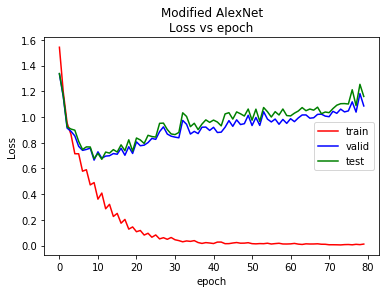

In [19]:
plot_loss(save_train_loss,save_valid_loss,save_test_loss)

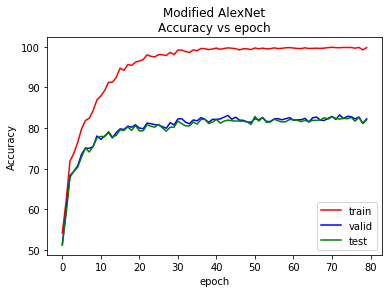

In [20]:
plot_accuracy(save_train_acc,save_valid_acc,save_test_acc)